##Section - A
Loading Data 

In [0]:
# Dataset load
from pyspark.sql import functions as F

df = spark.table("ab_nyc_2019_clean")
df.printSchema()
df.show(5)
print("Rows:", df.count())


root
 |-- host_id: long (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: long (nullable = true)
 |-- minimum_nights: long (nullable = true)
 |-- number_of_reviews: long (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: long (nullable = true)
 |-- availability_365: long (nullable = true)
 |-- has_review: long (nullable = true)
 |-- last_review_filled: date (nullable = true)
 |-- days_since_last_review: long (nullable = true)

+-------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------+------------------+----------------------+
|host_id|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|pri

##Section - B
Module 1 · Mining Large-Scale Datasets (Spark)

In [0]:
# EDA: missing values and summary stats
missing_df = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing_df.show()

df.describe(["price","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]).show()


+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------+------------------+----------------------+
|host_id|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|reviews_per_month|calculated_host_listings_count|availability_365|has_review|last_review_filled|days_since_last_review|
+-------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------------+------------------------------+----------------+----------+------------------+----------------------+
|      0|                  0|            0|       0|        0|        0|    0|             0|                0|                0|                             0|               0|         0|                 0|                     0|
+-------+-------------------+-------------+--------+---------+---------+----

In [0]:
# Listings distribution by borough and room type
df.groupBy("neighbourhood_group").count().show()
df.groupBy("room_type").count().show()


+-------------------+-----+
|neighbourhood_group|count|
+-------------------+-----+
|           Brooklyn|20041|
|          Manhattan|21488|
|             Queens| 5656|
|      Staten Island|  371|
|              Bronx| 1089|
+-------------------+-----+

+---------------+-----+
|      room_type|count|
+---------------+-----+
|   Private room|22273|
|Entire home/apt|25216|
|    Shared room| 1156|
+---------------+-----+



**Observation:**  
Manhattan dominates listing volume and pricing; Bronx and Staten Island are cheapest with lowest occupancy.  
This shows location strongly influences revenue potential.


##Section - C
Feature Engineering

In [0]:
# Occupancy rate & revenue features
df = df.withColumn(
    "occupancy_rate", 1.0 - (F.col("availability_365") / 365.0)
).withColumn(
    "demand_score", 0.7*F.col("number_of_reviews") + 0.3*F.col("reviews_per_month")
).withColumn(
    "annual_revenue", F.col("price") * 365 * F.col("occupancy_rate")
).withColumn(
    "location_config",
    F.concat_ws(" | ", "neighbourhood_group","neighbourhood","room_type")
)
df.select("price","occupancy_rate","demand_score","annual_revenue","location_config").show(5,truncate=False)


+-----+-------------------+------------------+------------------+-----------------------------------------+
|price|occupancy_rate     |demand_score      |annual_revenue    |location_config                          |
+-----+-------------------+------------------+------------------+-----------------------------------------+
|149  |0.0                |6.3629999999999995|0.0               |Brooklyn | Kensington | Private room     |
|225  |0.0273972602739726 |31.613999999999997|2250.0            |Manhattan | Midtown | Entire home/apt    |
|150  |0.0                |0.0               |0.0               |Manhattan | Harlem | Private room        |
|89   |0.46849315068493147|190.392           |15218.999999999998|Brooklyn | Clinton Hill | Entire home/apt|
|80   |1.0                |6.33              |29200.0           |Manhattan | East Harlem | Entire home/apt|
+-----+-------------------+------------------+------------------+-----------------------------------------+
only showing top 5 rows


In [0]:
# Aggregation by borough & room type
agg_df = (df.groupBy("neighbourhood_group","room_type")
            .agg(F.count("*").alias("listing_count"),
                 F.avg("price").alias("avg_price"),
                 F.avg("occupancy_rate").alias("avg_occ"),
                 F.avg("annual_revenue").alias("avg_revenue")))
agg_df.show(10,truncate=False)


+-------------------+---------------+-------------+------------------+------------------+------------------+
|neighbourhood_group|room_type      |listing_count|avg_price         |avg_occ           |avg_revenue       |
+-------------------+---------------+-------------+------------------+------------------+------------------+
|Brooklyn           |Private room   |10110        |72.88466864490603 |0.726643090389273 |18845.543818001977|
|Manhattan          |Entire home/apt|13053        |224.74450317934574|0.6809706266023987|52369.58821726806 |
|Manhattan          |Private room   |7955         |109.22225015713387|0.7218143151115421|26585.07944688875 |
|Brooklyn           |Entire home/apt|9520         |168.52069327731093|0.7343723379762878|43111.229831932775|
|Manhattan          |Shared room    |480          |88.97708333333334 |0.6203481735159821|21626.44375       |
|Queens             |Private room   |3370         |68.24421364985163 |0.59092801105646  |14249.335014836795|
|Staten Island     

%md
**Insights:**  
- Entire-home listings in Manhattan and Brooklyn yield the highest revenue.  
- Private-rooms in Queens provide moderate returns with steady demand.  
These aggregates help hosts choose profitable configurations.


##Section - D
Module 2 · Recommendation System (ALS)

In [0]:
# Prepare data for ALS
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

host_indexer = StringIndexer(inputCol="host_id",outputCol="user_id",handleInvalid="skip")
loc_indexer  = StringIndexer(inputCol="location_config",outputCol="item_id",handleInvalid="skip")

indexed = host_indexer.fit(df).transform(df)
indexed = loc_indexer.fit(indexed).transform(indexed)

train_df,test_df = indexed.randomSplit([0.8,0.2],seed=42)


In [0]:
# Train ALS & Evaluate
als = ALS(userCol="user_id",itemCol="item_id",ratingCol="occupancy_rate",
          nonnegative=True,coldStartStrategy="drop",maxIter=10,regParam=0.1,rank=10)
als_model = als.fit(train_df)
preds = als_model.transform(test_df)

evaluator = RegressionEvaluator(metricName="rmse",labelCol="occupancy_rate",predictionCol="prediction")
rmse = evaluator.evaluate(preds)
print(f"ALS RMSE: {rmse:.4f}")


ALS RMSE: 0.2793


In [0]:
# Top-5 recommendations for one host (Unity Catalog safe)
sample_user = indexed.select("user_id").distinct().limit(1).collect()[0]["user_id"]

# Only select item_id for ALS prediction input
items = indexed.select("item_id").dropDuplicates(["item_id"])

from pyspark.sql.functions import lit
pairs = items.withColumn("user_id", lit(sample_user))

user_preds = als_model.transform(pairs).orderBy(
    F.desc("prediction")
).limit(5)

display(user_preds)

item_id,user_id,prediction
497,308,0.498103
342,308,0.47915584
145,308,0.4564532
174,308,0.44349137
483,308,0.42568088


%md
**Interpretation:**  
The ALS model predicts the most promising listing configurations for a sample host.  
High predicted occupancy implies strong market demand for those room-type × location × price combinations.


##Section - E
Module 3 · Synthetic Data Generation (SDV)

In [0]:
# Install & Import SDV
%pip install sdv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 3.10.0
    Not uninstalling platformdirs at /databricks/python3/lib/python3.12/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-4cfe0b31-0dce-4723-ba27-eedeb7dd611e
    Can't uninstall 'platformdirs'. No files were found to uninstall.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Fit synthesizer & Sample
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
import matplotlib.pyplot as plt

cols = ["price","minimum_nights","number_of_reviews","reviews_per_month","availability_365","occupancy_rate"]
real_pd = df.select(cols).sample(fraction=0.3,seed=42).toPandas()

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_pd)

synth = GaussianCopulaSynthesizer(metadata)
synth.fit(real_pd)
synthetic = synth.sample(num_rows=5000)
synthetic.describe()


/local_disk0/.ephemeral_nfs/envs/pythonEnv-4cfe0b31-0dce-4723-ba27-eedeb7dd611e/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-4cfe0b31-0dce-4723-ba27-eedeb7dd611e/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365,occupancy_rate
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,140.156000,4.638400,27.198600,0.776078,121.344200,0.675626
std,95.849734,5.124305,53.766571,1.296801,132.914804,0.360871
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000254
25%,70.000000,1.000000,0.000000,0.030000,2.000000,0.357116
50%,119.000000,3.000000,4.000000,0.235000,56.000000,0.855215
75%,183.000000,6.000000,28.000000,0.990000,242.000000,0.994459
max,804.000000,52.000000,543.000000,15.320000,365.000000,1.000000


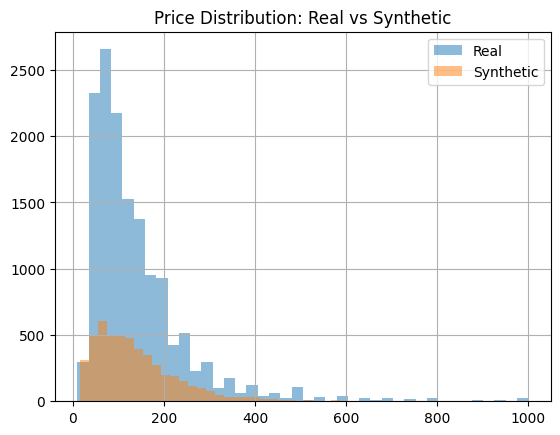

In [0]:
# Compare distributions
real_pd["price"].hist(bins=40,alpha=0.5)
synthetic["price"].hist(bins=40,alpha=0.5)
plt.legend(["Real","Synthetic"])
plt.title("Price Distribution: Real vs Synthetic")
plt.show()


%md
**Observation:**  
Synthetic price and occupancy distributions closely mirror the real dataset, validating model quality.  
This supports scenario testing and privacy-preserving data sharing.


##Section - F
Business Visualizations & Insights

%md
**Business Visualizations & Insights**

These charts translate analytics into clear decisions for Airbnb hosts.


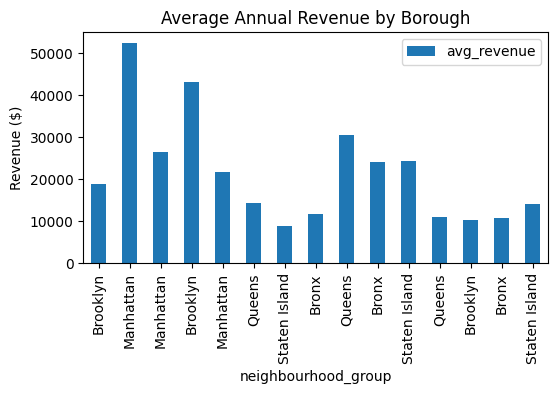

In [0]:
# Average revenue by borough
agg_pd = agg_df.toPandas()
agg_pd.plot(kind="bar",x="neighbourhood_group",y="avg_revenue",figsize=(6,3))
plt.title("Average Annual Revenue by Borough")
plt.ylabel("Revenue ($)")
plt.show()


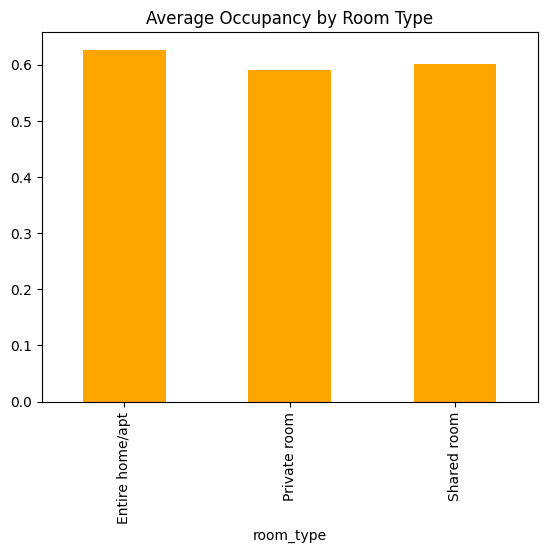

In [0]:
# Occupancy by room type
agg_pd.groupby("room_type")["avg_occ"].mean().plot(kind="bar",color="orange")
plt.title("Average Occupancy by Room Type")
plt.show()


**Business Insights:**  
- Entire-home listings in Manhattan generate highest returns.  
- Private rooms show stable demand across boroughs.  
- Synthetic data can extend future revenue forecasting scenarios.


##Section - G  
Cloud Pipeline Summary & Save Results

**Cloud Pipeline Summary**

All data processing, modeling, and visualization were executed on Databricks Cloud using Spark.  
Results are saved in Delta format to enable reproducibility and scalability.


In [0]:
# Save final Delta table 
df.write.format("delta").mode("overwrite").saveAsTable("workspace.default.airbnb_final_project")
